In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import pandas as pd
import random
from model_structure import get_preprocessing_transforms,BCNN, train_model, evaluate_model

In [2]:
INPUT_SIZE = 224
BATCH_SIZE = 32
DEVICE =torch.device('cuda' if torch.cuda.is_available() else 'cpu')#torch.device('cpu')

In [3]:

# Get transforms
train_transform, val_transform = get_preprocessing_transforms(INPUT_SIZE)

test_data_1_dir = 'data4model_1/test/'
test_data_2_dir = 'data4model_2/test/'
train_data_1_dir = 'data4model_1/train/'
train_data_2_dir = 'data4model_2/train/'

# Load data set
dataset_test_1 = datasets.ImageFolder(test_data_1_dir,transform=val_transform)
dataset_train_1 = datasets.ImageFolder(train_data_1_dir,transform=val_transform)
dataset_test_2 = datasets.ImageFolder(test_data_2_dir,transform=val_transform)
dataset_train_2 = datasets.ImageFolder(train_data_2_dir,transform=val_transform)
additional_set = datasets.ImageFolder('data4model_1/for_extra_test/',transform=val_transform)



additional_loader = DataLoader(additional_set, shuffle=False, batch_size=BATCH_SIZE)
test_loader_1 = DataLoader(dataset_test_1, shuffle=False, batch_size=BATCH_SIZE)
train_loader_1 = DataLoader(dataset_train_1, shuffle=False, batch_size=BATCH_SIZE)
test_loader_2 = DataLoader(dataset_test_2, shuffle=False, batch_size=BATCH_SIZE)
train_loader_2 = DataLoader(dataset_train_2, shuffle=False, batch_size=BATCH_SIZE)

dataSets =  {"Model_1:Train": train_loader_1,
        "Model_1:Test": test_loader_1,
        "Model_2:Train": train_loader_2,
        "Model_2:Test": test_loader_2,
        "Model_1:additional_set": additional_loader
        }

In [4]:
model_1_dir = 'best_model_1.pth'
model_2_dir = 'best_model_2.pth'

In [5]:
# Load the model
model_1 = BCNN().to(DEVICE)
weights = torch.load(model_1_dir, map_location=torch.device(DEVICE))
model_1.load_state_dict(weights)
model_1.eval()

model_2 = BCNN().to(DEVICE)
weights = torch.load(model_2_dir, map_location=torch.device(DEVICE))
model_2.load_state_dict(weights)
model_2.eval()

C:\Users\hskay\AppData\Local\Temp\ipykernel_17460\1438434258.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(model_1_dir, map_location=torch.device(

BCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout2d(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [6]:
for key in dataSets:
    print(key)
    if "Model_1" in key:
        model = model_1
    else:
        model = model_2
    
    results = evaluate_model(model.to(DEVICE), dataSets[key], DEVICE)
    print("Accuracy: ", results[0])
    print("F1 Score: ", results[1])
    print("confusion Matrix: \n",results[3])
    print("\n")

Model_1:Train
Accuracy:  0.9283333333333333
F1 Score:  0.9271926854046733
confusion Matrix: 
 [[1416   84]
 [ 131 1369]]


Model_1:Test
Accuracy:  0.87
F1 Score:  0.8617021276595744
confusion Matrix: 
 [[93  7]
 [19 81]]


Model_2:Train
Accuracy:  0.9436666666666667
F1 Score:  0.9452188006482982
confusion Matrix: 
 [[1373  127]
 [  42 1458]]


Model_2:Test
Accuracy:  0.89
F1 Score:  0.8981481481481481
confusion Matrix: 
 [[81 19]
 [ 3 97]]


Model_1:additional_set
Accuracy:  0.723422860712055
F1 Score:  0.7165172855313701
confusion Matrix: 
 [[2993 1007]
 [1207 2798]]




In [7]:
N_NEURONS = 1  # Number of random neurons to monitor
K_ROUND = 50  # Number of rounds to monitor
activation_values = {"Model_1":{},
                     "Model_2":{}}



In [8]:
def get_activation(name, model_name):
    def hook(model, input, output):
        output_relu = torch.nn.functional.relu(output) ### EXPLAIN WHY YOU PUT HERE
        if name == last_layer_name:
            activation_values[model_name][name] = output_relu.detach() 
            activation_values[model_name][f"{name}_softmax"] = torch.nn.functional.softmax(output_relu.detach(), dim=1) 
        else:
            activation_values[model_name][name] = output_relu.detach()
    return hook

def register_hooks(model,model_name):
    hooks = []
    layer_info = {}
    counter = 0

    last_linear_name = None
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Linear):
            last_linear_name = name
    
    global last_layer_name
    last_layer_name = last_linear_name

    for name, layer in model.named_modules():
        #if isinstance(layer, (nn.Conv2d, nn.Linear)):
            # Register hook for the full layer output
            #hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            
            if isinstance(layer, nn.Linear):
                layer_info[name] = {'type': f'{counter:02}-linear',}
                if name == last_linear_name:
                    layer_info[f"{name}_softmax"] = {'type': f'{counter:02}-softmax'}
                hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            elif isinstance(layer, nn.Conv2d):
                layer_info[name] = {'type': f'{counter:02}-conv'}
                hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            # elif isinstance(layer, nn.ReLU):
            #      layer_info[name] = {'type': f'{counter:02}-relu'}
            #      hooks.append(layer.register_forward_hook(get_activation(name,model_name)))
            # elif isinstance(layer, nn.MaxPool2d):
            #     layer_info[name] = {'type': f'{counter}-maxpool'}
            # elif isinstance(layer, nn.Dropout):
            #     layer_info[name] = {'type': f'{counter}-dropout'}
            # elif isinstance(layer, nn.Flatten):
            #     layer_info[name] = {'type': f'{counter}-flatten'}
            # elif isinstance(layer, nn.BatchNorm2d):
            #     layer_info[name] = {'type': f'{counter}-batchnorm'}
            # elif isinstance(layer, nn.AdaptiveAvgPool2d):
            #     layer_info[name] = {'type': f'{counter}-adaptiveavgpool'}
            # elif isinstance(layer, nn.Softmax):
            #     layer_info[name] = {'type': f'{counter}-softmax'}
            # else:
            #     layer_info[name] = {'type': f'{counter}-other'}
            counter += 1
    return hooks, layer_info

# Function to select random neuron indices
def select_random_neuron_indices(activations, layer_info, n_neurons=1):
    indices = {}
    
    for layer_name, layer_data in layer_info.items():
        if layer_name not in activations: 
                continue
        activation = activations[layer_name]
        
        flattened = activation.view(activation.shape[0],-1)
        positive_indices = np.where(flattened.cpu().numpy().squeeze()> 0)[0] 
        
        if len(positive_indices) == 0:
            #if no positive values, select random indices they are
            positive_indices = np.where(flattened.cpu().numpy().squeeze()== 0)[0]

        selected_indices = np.random.choice(
                positive_indices, 
                size=min(n_neurons, len(positive_indices)),
                replace=False
            )
            
        indices[layer_name] = {
                'neuron_idx': selected_indices,
                'type': layer_data['type'] 
            }
    
    return indices

def analyze_positive_activations(activations1, 
                               activations2,
                               layers1,
                               layers2, 
                               pic_index, 
                               prediction1,
                               prediction2,
                               model1_name="Model 1", 
                               model2_name="Model 2",
                               target=None,
                               ROUND=1
                               ):
    def process_layer_activations(activations, layers):
        layer_data = {}
        for layer_name, layer_info in layers.items():
            if layer_name not in activations:  # Skip if layer not in activations
                continue
                
            activation = activations[layer_name]
            flattened = activation.view(activation.shape[0], -1)
            
            neuron_indices = layers[layer_name]['neuron_idx']  # Will be length 1
            activation_values = flattened[:, neuron_indices]
            
            formatted_layer_name = f"{layer_info['type']}_{layer_name.split('.')[0]}"
            layer_data[formatted_layer_name] = {
                'indices': neuron_indices,
                'activations': activation_values
            }
            
        return layer_data

    # Process activations for both models
    data1 = process_layer_activations(activations1, layers1)
    data2 = process_layer_activations(activations2, layers2)

    # Create combined DataFrame
    combined_data = []
    
    # Find common layer names between both models sometimes it works
    common_layers = set(data1.keys()) & set(data2.keys())
    
    # Initialize the entry dictionary outside the loop
    entry = {
        'pic_id': pic_index,
        'round': ROUND
    }

    # Process all layers for a single entry
    for layer_name in common_layers:
        index1 = data1[layer_name]['indices'][0]
        index2 = data2[layer_name]['indices'][0]
        activation1 = data1[layer_name]['activations'][0][0]
        activation2 = data2[layer_name]['activations'][0][0]
        difference = activation1 - activation2
        
        # Add layer-specific information to the same entry
        entry[f'{model1_name}_{layer_name}_neuron_index'] = index1.item()
        entry[f'{model1_name}_{layer_name}_activation'] = activation1.item()
        entry[f'{model2_name}_{layer_name}_neuron_index'] = index2.item()
        entry[f'{model2_name}_{layer_name}_activation'] = activation2.item()
        entry[f'{layer_name}_difference'] = difference.item()

    # Add predictions and target at the end
    entry.update({
        'prediction1': prediction1,
        'prediction2': prediction2,
        'target': target
    })

    # Append the single entry
    combined_data.append(entry)
    df_combined = pd.DataFrame(combined_data)

    # Create column order
    columns = ['pic_id', 'round']
    for layer_name in common_layers:
        columns.extend([
            f'{model1_name}_{layer_name}_neuron_index',
            f'{model1_name}_{layer_name}_activation',
            f'{model2_name}_{layer_name}_neuron_index',
            f'{model2_name}_{layer_name}_activation',
            f'{layer_name}_difference'
        ])
    columns.extend(['prediction1', 'prediction2', 'target'])

    # Reorder columns
    df_combined = df_combined[columns]
    return df_combined

 


In [18]:
classes = {
    0: 'cat',
    1: 'dog'
}

In [19]:
the_class = 0 # 0 cat or squirrel, 1 dog

In [20]:
with torch.no_grad():
    images = [(img, idx) for idx, (img, label) in enumerate(dataSets["Model_1:additional_set"].dataset) 
                if label == the_class and model_1(img.unsqueeze(0).to(DEVICE))
                                          .argmax().item() == the_class]

In [21]:
all_dfs = []

for image, pic_index in images:
    activation_values = {"Model_1":{},
                        "Model_2":{}}

    hooks1, layers1 = register_hooks(model_1, "Model_1")
    hooks2, layers2 = register_hooks(model_2, "Model_2")

    with torch.no_grad():
        pred1 = model_1(image.unsqueeze(0).to(DEVICE))
        pred2 = model_2(image.unsqueeze(0).to(DEVICE))
            
    for K in range(K_ROUND):

        indices1 = select_random_neuron_indices(activation_values["Model_1"], layers1)
        indices2 = select_random_neuron_indices(activation_values["Model_2"], layers2)

        df_combined = analyze_positive_activations(
            activation_values["Model_1"], 
            activation_values["Model_2"],
            indices1,
            indices2,
            pic_index,
            pred1.argmax().item(),
            pred2.argmax().item(),
            "Model_1",
            "Model_2",
            target=classes[the_class],
            ROUND = K
        )
        
        # Add to list
        all_dfs.append(df_combined)

        print('\r ',"pic_index: ", pic_index, "round: ",K, end="")

    # Remove hooks
    for hook in hooks1 + hooks2:
        hook.remove()

  pic_index:  3998 round:  49

In [22]:
combined_df = pd.concat(all_dfs, axis=0)
combined_df = combined_df.reset_index()
# combined_df = combined_df.rename(columns={'index': 'layer_name'})

combined_df.to_csv(f'model_random_paths_for_{classes[the_class]}_and_{K_ROUND}_Rounds.csv', index=False)
combined_df

,index,pic_id,round,Model_1_02-conv_features_neuron_index,Model_1_02-conv_features_activation,Model_2_02-conv_features_neuron_index,Model_2_02-conv_features_activation,02-conv_features_difference,Model_1_06-conv_features_neuron_index,Model_1_06-conv_features_activation,...,Model_2_10-conv_features_activation,10-conv_features_difference,Model_1_16-linear_classifier_neuron_index,Model_1_16-linear_classifier_activation,Model_2_16-linear_classifier_neuron_index,Model_2_16-linear_classifier_activation,16-linear_classifier_difference,prediction1,prediction2,target
0,0,0,0,1599527,0.117511,1471476,0.071648,0.045863,731624,0.004970,...,0.053449,-0.040390,422,0.689835,412,1.639765,-0.949930,0,0,cat
1,0,0,1,82654,0.007831,1449152,0.008279,-0.000447,91695,0.017880,...,0.047712,-0.035901,342,0.897832,154,0.263257,0.634575,0,0,cat
2,0,0,2,1232015,0.014102,84476,0.025315,-0.011213,297054,0.051144,...,0.028027,-0.023305,349,1.561571,207,1.120091,0.441480,0,0,cat
3,0,0,3,534217,0.027586,1415347,0.031820,-0.004234,631260,0.009144,...,0.007035,0.011581,61,0.932505,193,1.681823,-0.749319,0,0,cat
4,0,0,4,1398381,0.085222,177337,0.015233,0.069989,527415,0.052118,...,0.036354,-0.007163,177,0.058569,122,0.816507,-0.757938,0,0,cat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149645,0,3998,45,290720,0.047797,50071,0.328865,-0.281067,253249,0.025035,...,0.056235,-0.032355,299,0.226029,122,1.156599,-0.930570,0,1,cat
149646,0,3998,46,1605597,0.921307,706782,0.087455,0.833852,220734,0.123498,...,0.011147,0.035410,412,0.788340,144,1.255728,-0.467388,0,1,cat
149647,0,3998,47,64795,0.001276,705648,0.093930,-0.092654,21978,0.088088,...,0.022097,0.012489,403,0.258183,13,1.829246,-1.571062,0,1,cat
149648,0,3998,48,1578960,0.010781,479360,0.229087,-0.218306,137689,0.009975,...,0.065424,-0.052235,433,0.056659,83,0.559262,-0.502603,0,1,cat


In [14]:
combined_df = pd.read_csv(f'model_random_paths_for_{classes[the_class]}_and_{K_ROUND}_Rounds.csv')
difference_cols = [col for col in combined_df.columns if 'difference' in col]
combined_df["Total_difference"] = np.abs(combined_df[difference_cols]).sum(axis=1)
combined_df["Total_difference"].mean(), combined_df["Total_difference"].std()

(3.2819015689628115, 2.0304269168523272)

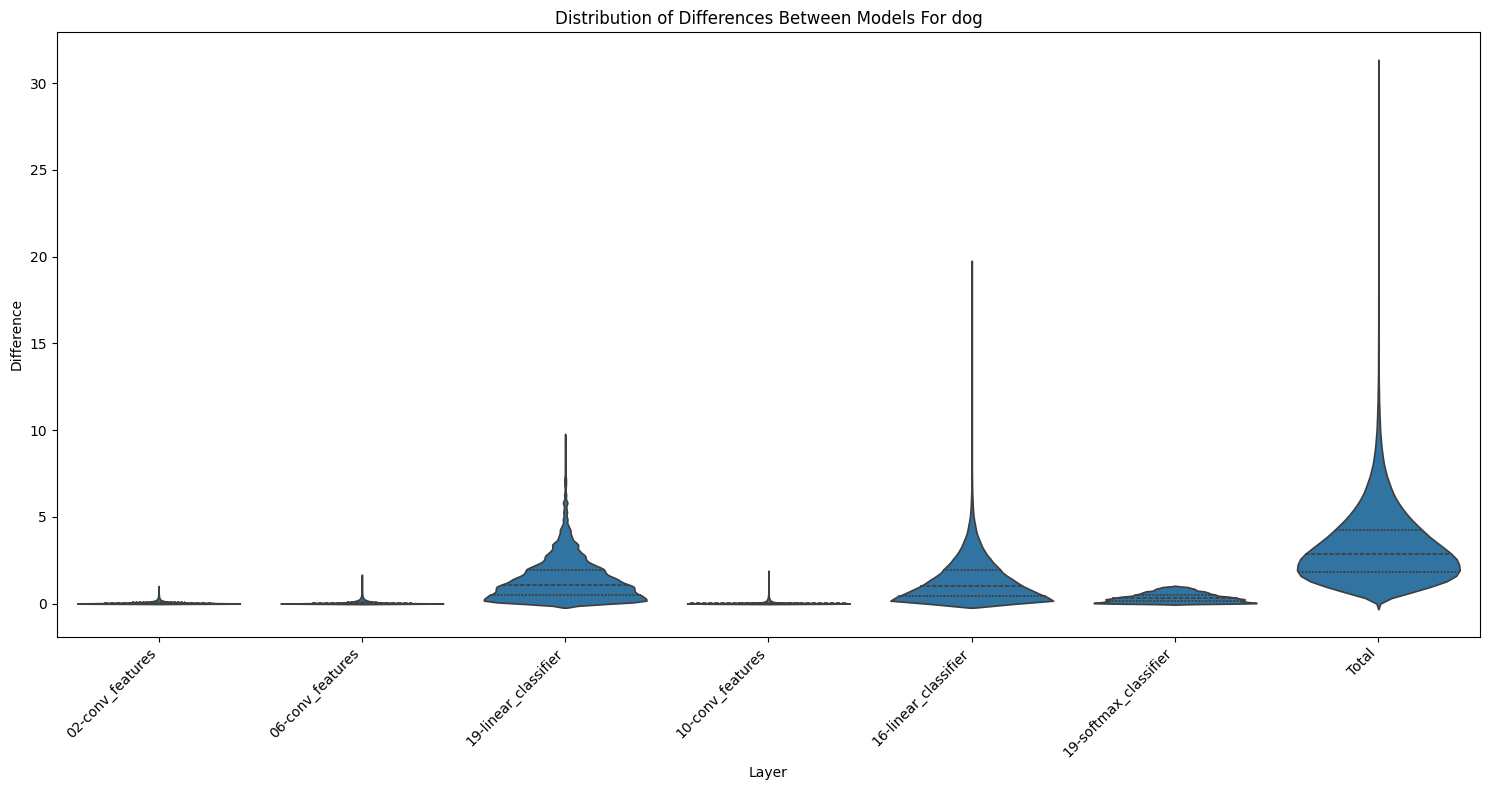

In [15]:
ordered_cols = []
softmax_cols = []
difference_cols = [col for col in combined_df.columns if 'difference' in col]
for col in difference_cols:
    if 'softmax' in col.lower():
        softmax_cols.append(col)
    else:
        ordered_cols.append(col)

difference_cols = ordered_cols[:-1] + softmax_cols + ordered_cols[-1:]

plt.figure(figsize=(15, 8))
    
# Prepare data for plotting
plot_data = []
for col in difference_cols:
    layer_name = col.replace('_difference', '')  # Extract layer name
    temp_data = pd.DataFrame({
        'Layer': layer_name,
        'Difference': np.abs(combined_df[col])
    })
    plot_data.append(temp_data)

# Combine all data
plot_df = pd.concat(plot_data, ignore_index=True)

# Create violin plot
sns.violinplot(data=plot_df, 
                x='Layer', 
                y='Difference',
                inner='quartile',
                density_norm='count')

# Customize plot
plt.xticks(rotation=45, ha='right')
plt.title(f'Distribution of Differences Between Models For {classes[the_class]}')
plt.xlabel('Layer')
plt.ylabel('Difference')

# Adjust layout
plt.tight_layout()

# Save plot
save_path = f'model_differences_violin_plot_for_{classes[the_class]}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

In [17]:
combined_df["Total_difference"].describe()

count    139900.000000
mean          3.281902
std           2.030427
min           0.070951
25%           1.822145
50%           2.857156
75%           4.276481
max          30.962108
Name: Total_difference, dtype: float64

In [23]:
combined_df = pd.read_csv(f'model_random_paths_for_{classes[the_class]}_and_{K_ROUND}_Rounds.csv')
difference_cols = [col for col in combined_df.columns if 'difference' in col]
combined_df["Total_difference"] = np.abs(combined_df[difference_cols]).sum(axis=1)
combined_df["Total_difference"].mean(), combined_df["Total_difference"].std()

(2.589915360412554, 1.7763223682897886)

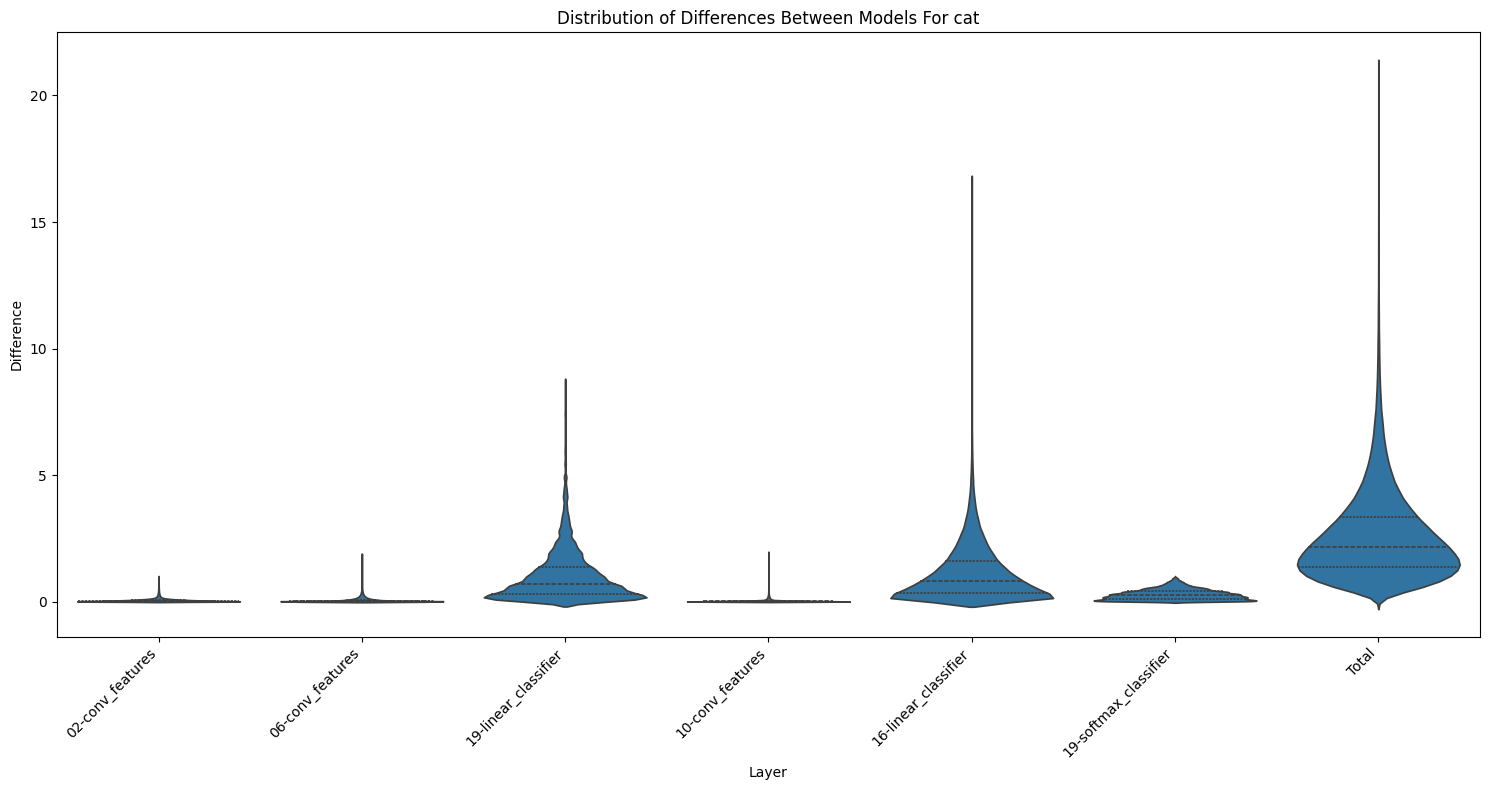

In [24]:
ordered_cols = []
softmax_cols = []
difference_cols = [col for col in combined_df.columns if 'difference' in col]
for col in difference_cols:
    if 'softmax' in col.lower():
        softmax_cols.append(col)
    else:
        ordered_cols.append(col)

difference_cols = ordered_cols[:-1] + softmax_cols + ordered_cols[-1:]

plt.figure(figsize=(15, 8))
    
# Prepare data for plotting
plot_data = []
for col in difference_cols:
    layer_name = col.replace('_difference', '')  # Extract layer name
    temp_data = pd.DataFrame({
        'Layer': layer_name,
        'Difference': np.abs(combined_df[col])
    })
    plot_data.append(temp_data)

# Combine all data
plot_df = pd.concat(plot_data, ignore_index=True)

# Create violin plot
sns.violinplot(data=plot_df, 
                x='Layer', 
                y='Difference',
                inner='quartile',
                density_norm='count')

# Customize plot
plt.xticks(rotation=45, ha='right')
plt.title(f'Distribution of Differences Between Models For {classes[the_class]}')
plt.xlabel('Layer')
plt.ylabel('Difference')

# Adjust layout
plt.tight_layout()

# Save plot
save_path = f'model_differences_violin_plot_for_{classes[the_class]}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

In [25]:
combined_df["Total_difference"].describe()

count    149650.000000
mean          2.589915
std           1.776322
min           0.035537
25%           1.354997
50%           2.170894
75%           3.342709
max          21.079443
Name: Total_difference, dtype: float64